In [3]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))
        
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
#ROUND 1: GDB TRAINING BY THE 100K

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#training data
df = pd.read_csv('../data/GDB/GDB17.1000000', names=['smiles'])
data_size = 100000
max_data = df.shape[0]
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length)

for p in range(0,10):
    selected = df['smiles'][data_size*p:data_size*(p+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    print(values[0])
    print(values.iloc[-1])
    print(len(values))
    padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
    X_train = np.zeros((data_size, smile_max_length, chars_in_dict), dtype=np.float32)
    
    for i, smile in enumerate(padded_smiles):
        for j, char in enumerate(smile):
            X_train[i, j, char_to_index[char]] = 1
    X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
    chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
    chemvae.save('gen2_2mol_1mil_GDB17_{}.h5'.format(p+1))

CCC(N)C(C)C1(CC#C)CC(CC)N=CN1.CC1=C2N=CC(NCC=O)=C(F)N2C(C=O)=N1
CC1=C2N=CC(NCC=O)=C(F)N2C(C=O)=N1.CCC(N)C(C)C1(CC#C)CC(CC)N=CN1
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2757s 31ms/step - loss: 4.7901 - acc: 0.6336 - val_loss: 4.3106 - val_acc: 0.6578
CC(CN)C1=CN2C(N1)=C(Br)C(N)=C(Br)C2=N.CC12OC3C1C(C=C2)N1CCC2=CSC3=C12
CC12OC3C1C(C=C2)N1CCC2=CSC3=C12.CC(CN)C1=CN2C(N1)=C(Br)C(N)=C(Br)C2=N
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2772s 31ms/step - loss: 4.2467 - acc: 0.6585 - val_loss: 4.1893 - val_acc: 0.6611
CC12COC(=O)N1C1(CS(=O)(=O)NC21C)C=O.CC1C=CCC1NCCCNCC(C)=NO
CC1C=CCC1NCCCNCC(C)=NO.CC12COC(=O)N1C1(CS(=O)(=O)NC21C)C=O
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2768s 31ms/step - loss: 4.1297 - acc: 0.6635 - val_loss: 4.1782 - val_acc: 0.6604
CC1(C=C2C(O)C3NCC1(C)C23N)

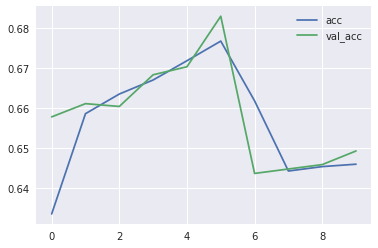

In [7]:
phase_1_history = {'acc': [0.6336, 0.6586, 0.6635, 0.6670, 0.6718, 0.6767, 0.6618, 0.6443, 0.6454, 0.6460],
                   'val_acc': [0.6578, 0.6611, 0.6604, 0.6683, 0.6703, 0.6829, 0.6437, 0.6448, 0.6459, 0.6493]}
plt.plot(phase_1_history['acc'], label='acc')
plt.plot(phase_1_history['val_acc'], label='val_acc')
plt.legend()

In [3]:
#ROUND 2: GDB TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_1mil_GDB17_10.h5')

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        for i, smile in enumerate(padded_smiles):
            for j, char in enumerate(smile):
                X_train[i, j, char_to_index[char]] = 1
        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)

CC1C(=N)N2CC(=O)CN=C2C2CCCC12O.CC1NCC2COC(COCC#C)OC2C1C
CC1NCC2COC(COCC#C)OC2C1C.CC1C(=N)N2CC(=O)CN=C2C2CCCC12O
500000
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14209s 32ms/step - loss: 4.5817 - acc: 0.6447 - val_loss: 4.4509 - val_acc: 0.6547
gen2_2mol_50mil_GDB17_1_1.h5
CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO.CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N
CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N.CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO
499999
Train on 449999 samples, validate on 50000 samples
Epoch 1/1
449999/449999 [==============================] - 14190s 32ms/step - loss: 4.4024 - acc: 0.6578 - val_loss: 4.3185 - val_acc: 0.6634
gen2_2mol_50mil_GDB17_1_2.h5
CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1.CC1CC2CNCCNCC(CN2)NCCN1
CC1CC2CNCCNCC(CN2)NCCN1.CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1
500000
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14314s 32ms/step - loss: 4.3197 - acc: 0.6644 - val_loss: 4.6631 - val_ac

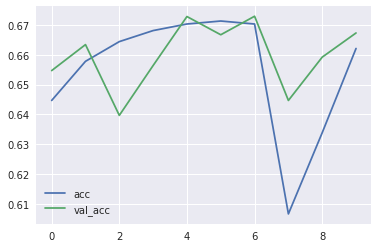

In [8]:
phase_1_history = {'acc': [0.6447, 0.6578, 0.6644, 0.6681, 0.6703, 0.6713, 0.6703, 0.6067, 0.6339, 0.6621],
                   'val_acc': [0.6547, 0.6634, 0.6397, 0.6564, 0.6728, 0.6667, 0.6729, 0.6447, 0.6592, 0.6673]}
plt.plot(phase_1_history['acc'], label='acc')
plt.plot(phase_1_history['val_acc'], label='val_acc')
plt.legend()

In [2]:
#ROUND 3: MIX TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_50mil_GDB17_5_2.h5')

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        
        salts_added = 0
        for i, smile in enumerate(padded_smiles):
            #randomly select salt or GDB
            linearly_scaled_prob = random.random() < i/data_epoch_size
            if linearly_scaled_prob:
                salts_added += 1
                smile = random.choice(salts)
            for j, char in enumerate(smile[:102]):
                X_train[i, j, char_to_index[char]] = 1
        print("salts added: {}".format(salts_added))

        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_num_mix_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)

CC1C(=N)N2CC(=O)CN=C2C2CCCC12O.CC1NCC2COC(COCC#C)OC2C1C
CC1NCC2COC(COCC#C)OC2C1C.CC1C(=N)N2CC(=O)CN=C2C2CCCC12O
500000
salts added: 249401
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14353s 32ms/step - loss: 4.9771 - acc: 0.3916 - val_loss: 4.9265 - val_acc: 0.3806
gen2_2mol_50mil_GDB17_num_mix_1_1.h5
CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO.CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N
CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N.CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO
499999
salts added: 249822
Train on 449999 samples, validate on 50000 samples
Epoch 1/1
449999/449999 [==============================] - 22971s 51ms/step - loss: 4.7755 - acc: 0.4049 - val_loss: 4.5014 - val_acc: 0.4983
gen2_2mol_50mil_GDB17_num_mix_1_2.h5
CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1.CC1CC2CNCCNCC(CN2)NCCN1
CC1CC2CNCCNCC(CN2)NCCN1.CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1
500000
salts added: 250159
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================]

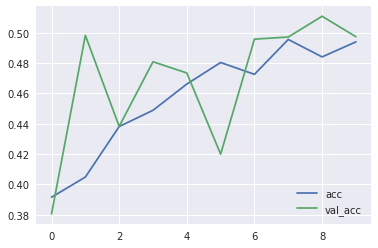

In [9]:
phase_2_history = {'acc': [0.3916, 0.4049, 0.4382, 0.4489, 0.4662, 0.4804, 0.4726, 0.4956, 0.4841, 0.4940],
                   'val_acc': [0.3806, 0.4983, 0.4383, 0.4809, 0.4735, 0.4200, 0.4958, 0.4972, 0.5109, 0.4974]}
plt.plot(phase_2_history['acc'], label='acc')
plt.plot(phase_2_history['val_acc'], label='val_acc')
plt.legend()

In [2]:
#ROUND 4: SALT TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_50mil_GDB17_num_mix_5_2.h5')

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        
        salts_added = 0
        for i, smile in enumerate(padded_smiles):
            #randomly select salt or GDB
#             linearly_scaled_prob = random.random() < i/data_epoch_size
#             if linearly_scaled_prob:
            salts_added += 1
            smile = random.choice(salts)
            for j, char in enumerate(smile[:102]):
                X_train[i, j, char_to_index[char]] = 1
        print("gdb entries replaced with salts: {}".format(salts_added))

        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        history = chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)
        with open('history_{}.json'.format(name), 'w') as f:
            json.dump(history.history, f)

CC1C(=N)N2CC(=O)CN=C2C2CCCC12O.CC1NCC2COC(COCC#C)OC2C1C
CC1NCC2COC(COCC#C)OC2C1C.CC1C(=N)N2CC(=O)CN=C2C2CCCC12O
500000
gdb entries replaced with salts: 500000
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14846s 33ms/step - loss: 3.0304 - acc: 0.3774 - val_loss: 2.8976 - val_acc: 0.4205
gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_1_1.h5
CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO.CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N
CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N.CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO
499999
gdb entries replaced with salts: 499999
Train on 449999 samples, validate on 50000 samples
Epoch 1/1
449999/449999 [==============================] - 14600s 32ms/step - loss: 3.2862 - acc: 0.3258 - val_loss: 3.0789 - val_acc: 0.3135
gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_1_2.h5
CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1.CC1CC2CNCCNCC(CN2)NCCN1
CC1CC2CNCCNCC(CN2)NCCN1.CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1
500000
gdb entries replaced with salts: 500000
Train on 450000 samples, valida

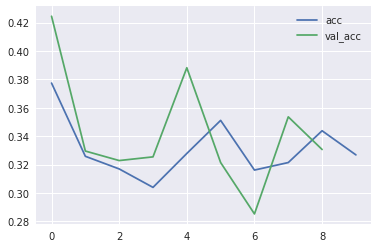

In [10]:
phase_3_history = {'acc': [0.3774, 0.3258, 0.3169, 0.3039, 0.3278, 0.3511, 0.3161, 0.3214, 0.3438, 0.3268],
                   'val_acc': [0.4245, 0.3295, 0.3228, 0.3254, 0.3882, 0.3214, 0.2852, 0.3536, 0.3306]}
plt.plot(phase_3_history['acc'], label='acc')
plt.plot(phase_3_history['val_acc'], label='val_acc')
plt.legend()